# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [2]:
# load all the data

azdias = pd.read_csv('azdias.csv')
customers = pd.read_csv('customers.csv')
mailout_train = pd.read_csv('mailout_train.csv')
mailout_test = pd.read_csv('mailout_test.csv')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(azdias.shape)
print(customers.shape)
print(mailout_train.shape)
print(mailout_test.shape)

(891221, 367)
(191652, 370)
(42962, 368)
(42833, 367)


In [4]:
# remove first columns (Unnamed: 0)
azdias = azdias.iloc[:, 1:]
customers = customers.iloc[:, 1:]
mailout_train = mailout_train.iloc[:, 1:]
mailout_test = mailout_test.iloc[:, 1:]

# Data Exploration and ad-hoc Data Cleaning

In [5]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [6]:
# Check columns 18 and 19 to confirm their datatypes, as prompted by the error above while loading the data
azdias.iloc[:, 18:20].columns.values

array(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype=object)

In [7]:
# Look at CAMEO_INTL
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [8]:
# Fill in NaNs and combine sparse data
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].fillna(0)

azdias['CAMEO_INTL_2015'].replace('XX', '00', inplace=True)

In [9]:
azdias['CAMEO_INTL_2015'].unique()

array([0, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', '00'],
      dtype=object)

**Taking a closer look into the data, I realized that CAMEO_DEUG_2015 has actually been factored into the CAMEO_DEU_2015 feature. The numbers in the former form represent the first digit of the variables in the latter.**

**We will consider engineering new features out of CAMEO_DEU_2015 at a later part. Till then, we fill in missing values.** 

In [10]:
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [11]:
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].fillna('00')

In [12]:
azdias['CAMEO_DEU_2015'].replace('XX', '00', inplace=True)

In [13]:
# Do a check
azdias['CAMEO_DEU_2015'].unique()

array(['00', '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

**Drop CAMEO_DEUG_2015, which is redundant**

In [14]:
# Drop CAMEO_DEUG_2015 since we don't need it anymore
azdias.drop(columns=['CAMEO_DEUG_2015'], axis=1, inplace=True)

In [15]:
azdias.shape

(891221, 365)

**Preparation for feature engineering (CAMEO_INTL_2015)**

In [16]:
# replace '0' with '00' to prepare for feature engineering later
azdias['CAMEO_INTL_2015'].replace(0, '00', inplace=True)
azdias['CAMEO_INTL_2015'].unique()

array(['00', 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45'],
      dtype=object)

In [17]:
# convert all values to string
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].apply(lambda x: str(x))
azdias['CAMEO_INTL_2015'].unique()

array(['00', '51.0', '24.0', '12.0', '43.0', '54.0', '22.0', '14.0',
       '13.0', '15.0', '33.0', '41.0', '34.0', '55.0', '25.0', '23.0',
       '31.0', '52.0', '35.0', '45.0', '44.0', '32.0', '22', '24', '41',
       '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55',
       '31', '32', '15', '13', '43', '33', '45'], dtype=object)

## Check for Missing Values

In this section, we attempt to check for columns with a large proportion of missing values. If the number of missing values is above a certain threshold, we remove that column.

**Handle columns**

In [18]:
# Inspect the number of missing data that each column has, and rank them in descending order
azdias.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                    890016
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
EXTSEL992                      654153
KK_KUNDENTYP                   584612
ALTERSKATEGORIE_FEIN           262947
D19_LOTTO                      257113
D19_LETZTER_KAUF_BRANCHE       257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_SOZIALES                   257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
KBA05_MOTOR                    133324
KBA05_MOD8                     133324
KBA05_MOD4                     133324
KBA05_MOD3                     133324
KBA05_MOD2                     133324
KBA05_SEG1                     133324
KBA05_MOD1                     133324
KBA05_MAXVORB                  133324
KBA05_MAXSEG                   133324
KBA05_MAXHERST                 133324
KBA05_MAXBJ 

In [19]:
azdias.isnull().sum().describe()

count       365.000000
mean      90947.906849
std      108765.511354
min           0.000000
25%           0.000000
50%      105800.000000
75%      107602.000000
max      890016.000000
dtype: float64

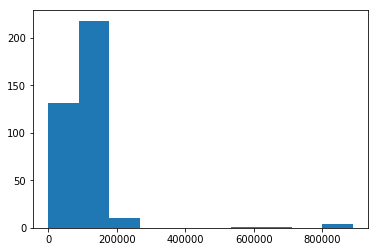

In [20]:
# Obtain a visual representation using a histogram
plt.hist(x=azdias.isnull().sum(), bins=10)
plt.show()

From the data we collected above, we can infer that **75% of the data have 107602 missing data or less**. This was visualized using the histogram plot of column counts vs missing value counts.

We will set the threshold at **200,000** missing values for deciding which columns to keep.

Columns with missing entries greater than this value will be dropped.

In [21]:
low_missing_col = azdias.isnull().sum()[azdias.isna().sum() < 200000]

In [22]:
azdias_col_cleaned = azdias[low_missing_col.index]

In [23]:
azdias_col_cleaned.shape

(891221, 349)

**Handle rows**

In [24]:
# rank rows by the number of missing data they have, in descending order
missing_rows = azdias_col_cleaned.isnull().sum(axis=1).sort_values(ascending=False)
missing_rows.describe()

count    891221.000000
mean         29.098624
std          72.293278
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         241.000000
dtype: float64

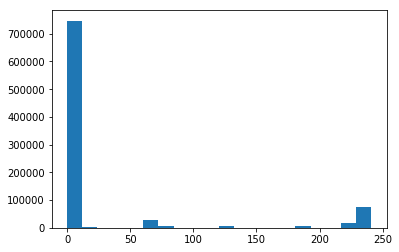

In [25]:
# plot a histogram for better visualization
plt.hist(x=missing_rows, bins=20)
plt.show()

From the data above, we can infer that more than 75% of our observations (rows) have fewer than 50 missing values. The maximum number of missing values for a row is 241.

We shall set the threshold to 50. **Observations with more than 50 missing values will be dropped**.

In [26]:
low_missing_rows = missing_rows[missing_rows < 50] 

In [27]:
low_missing_rows.index

Int64Index([847374,  59367, 199102, 364950, 445666, 663079, 166401, 108600,
            118129, 684056,
            ...
            556682, 556681, 556679, 556678, 556677, 556676, 556675, 556672,
            556670, 445610],
           dtype='int64', length=751331)

In [28]:
azdias_cleaned_rowcol = azdias_col_cleaned.loc[low_missing_rows.index, :]

azdias_cleaned_rowcol.shape

(751331, 349)

### Categorical data exploration

In [29]:
# categorical data exploration
azdias_cleaned_rowcol.select_dtypes(include=['object']).describe()

,CAMEO_DEU_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
count,751331,751331,751331,751331
unique,45,43,2825,2
top,6B,51,1992-02-10 00:00:00,W
freq,54368,75961,379434,591679


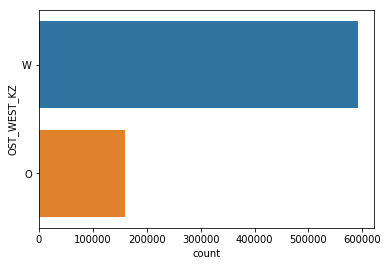

In [30]:
sns.countplot(y='OST_WEST_KZ', data=azdias_cleaned_rowcol)
plt.show()

### Numeric Data Exploration

In [31]:
azdias_cleaned_rowcol.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,7.513310e+05,751331.000000,751331.000000,751331.000000,751331.000000,747987.000000,751331.000000,751331.000000,751331.000000,751331.000000,...,744046.000000,749120.000000,749120.000000,749120.000000,719848.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000
mean,6.367752e+05,-0.293083,4.439994,10.819096,8.508822,0.041128,0.144063,1.728602,7.791223,0.004139,...,2.420408,6.043456,7.558340,5.941136,4.058655,7.962734,4.053932,3.400596,1.521717,2.822422
std,2.580028e+05,1.234016,3.649624,7.635330,15.663400,0.319720,0.485299,1.162490,14.399861,0.068283,...,1.163156,2.855643,3.257749,2.785767,1.894214,1.890432,1.891965,1.404571,0.499528,1.081793
min,1.916530e+05,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.132270e+05,-1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,2.000000,4.000000,6.000000,4.000000,3.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.349700e+05,-1.000000,3.000000,13.000000,4.000000,0.000000,0.000000,1.000000,4.000000,0.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.617140e+05,1.000000,9.000000,17.000000,10.000000,0.000000,0.000000,2.000000,9.000000,0.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082872e+06,3.000000,9.000000,21.000000,536.000000,20.000000,11.000000,45.000000,449.000000,4.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


### Drop unwanted features

In [32]:
azdias_cleaned_rowcol = azdias_cleaned_rowcol.drop(['LNR', 'EINGEFUEGT_AM'], axis=1)

## Feature Engineering

In [33]:
# Create new features by splitting CAMEO_INTL_2015's variables
azdias_cleaned_rowcol['WEALTH_LEVEL'] = azdias_cleaned_rowcol['CAMEO_INTL_2015'].apply(lambda x: int(x[0]))
azdias_cleaned_rowcol['FAMILY_AGE_BAND'] = azdias_cleaned_rowcol['CAMEO_INTL_2015'].apply(lambda x: int(x[1]))

azdias_cleaned_rowcol.loc[:, ['WEALTH_LEVEL', 'FAMILY_AGE_BAND']].head()
                                                                            

,WEALTH_LEVEL,FAMILY_AGE_BAND
847374,1,4
59367,2,4
199102,4,1
364950,2,2
445666,5,4


In [34]:
# Then we can drop CAMEO_INTL_2015
azdias_cleaned_rowcol.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

In [35]:
# check categorical data
azdias_cleaned_rowcol.select_dtypes(include=['object']).describe()

,CAMEO_DEU_2015,OST_WEST_KZ
count,751331,751331
unique,45,2
top,6B,W
freq,54368,591679


#### One-hot encoding

Create dummy variables for the categorical data. Doing so provides a binary representation of each variable in these categorical features, so that our classifier can accept them as training inputs.

In [36]:
# get dummy variables for categorical features
azdias_cleaned_rowcol = pd.get_dummies(azdias_cleaned_rowcol, columns=azdias_cleaned_rowcol.select_dtypes(include=['object']).columns.values)   

Once we are done creating dummy variables, remove the original categorical features.

In [37]:
azdias_cleaned_rowcol.drop(azdias_cleaned_rowcol.select_dtypes(include=['object']).columns.values, axis=1, inplace=True)

In [38]:
# check that the categorical features have been removed.
azdias_cleaned_rowcol.select_dtypes(include=['object']).columns.values

array([], dtype=object)

### Handle missing numeric data

Missing numerical data will be handled first by **flagging the observation with an indicator variable** of missingness- 0 for not missing, 1 for missing.

Then, **fill the original missing value with 0** just so to meet our classifier's input requirements. 

This is so that our model can **estimate the optimal constant for missingness**, instead of filling the missing values with the mean or median.

In [39]:
# Create new indicator features for columns that have missing data, and fill them up with 0 or 1
for col in azdias_cleaned_rowcol:
    if azdias_cleaned_rowcol[col].isnull().sum() > 0:
        azdias_cleaned_rowcol[f'{col}_is_missing'] = azdias_cleaned_rowcol[col].isnull().astype(int)

In [40]:
# After flagging, fill up the missing values with 0
azdias_cleaned_rowcol.fillna(0, inplace=True)

In [41]:
# check that the total sum of values in the series of missing value flags is 0 (ie no missing values)
azdias_cleaned_rowcol.isnull().sum().sum()

0

In [42]:
# tidy up the variable name
azdias_cleaned = azdias_cleaned_rowcol

## Exploring the `customers` dataset

In [155]:
# inspect new numeric feature 'ONLINE_PURCHASE'
customers['ONLINE_PURCHASE'].describe()

count    191652.000000
mean          0.090247
std           0.286536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ONLINE_PURCHASE, dtype: float64

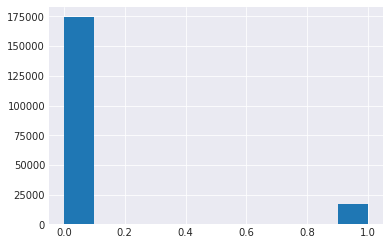

In [156]:
plt.hist(customers['ONLINE_PURCHASE'])
plt.show()

#### Check for sparse columns

In [43]:
customers.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                  191416
ALTER_KIND3                  190377
ALTER_KIND2                  186552
ALTER_KIND1                  179886
KK_KUNDENTYP                 111937
EXTSEL992                     85283
KBA05_SEG7                    55980
KBA05_KW1                     55980
KBA05_SEG4                    55980
KBA05_SEG5                    55980
KBA05_SEG6                    55980
KBA05_MAXAH                   55980
KBA05_SEG8                    55980
KBA05_KW2                     55980
KBA05_VORB0                   55980
KBA05_KRSZUL                  55980
KBA05_VORB1                   55980
KBA05_KRSVAN                  55980
KBA05_KRSOBER                 55980
KBA05_SEG9                    55980
MOBI_REGIO                    55980
KBA05_KW3                     55980
KBA05_SEG3                    55980
KBA05_KRSHERST3               55980
KBA05_MAXBJ                   55980
KBA05_MAXHERST                55980
KBA05_MAXSEG                  55980
KBA05_MAXVORB               

In [44]:
missing_cols = customers.isnull().sum().describe()
missing_cols

count       369.000000
mean      37573.230352
std       29023.125309
min           0.000000
25%           0.000000
50%       51281.000000
75%       51281.000000
max      191416.000000
dtype: float64

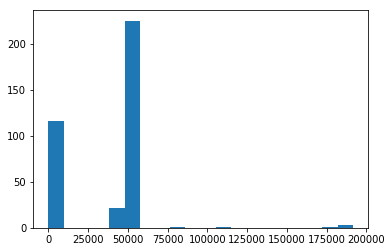

In [45]:
plt.hist(x=customers.isnull().sum(), bins=20)
plt.show()

#### Check for sparse rows

In [46]:
customers.isnull().sum(axis=1).describe()

count    191652.000000
mean         72.342172
std         107.600590
min           0.000000
25%           4.000000
50%           5.000000
75%         225.000000
max         259.000000
dtype: float64

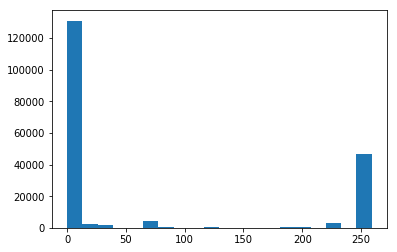

In [47]:
plt.hist(x=customers.isnull().sum(axis=1), bins=20)
plt.show()

#### Explore categorical data

In [48]:
customers.select_dtypes(include=['object']).describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
count,141224,141224,141224,143955,141725,141725,191652,191652
unique,45,19,43,35,3034,2,3,2
top,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
freq,11208,17574,14708,31910,64744,130382,100860,132238


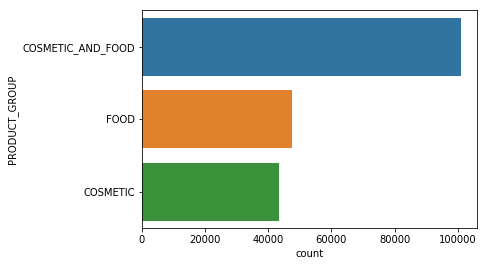

In [49]:
# count plot for product data (categorical) for illustration purposes
sns.countplot(y='PRODUCT_GROUP', data=customers)
plt.show()

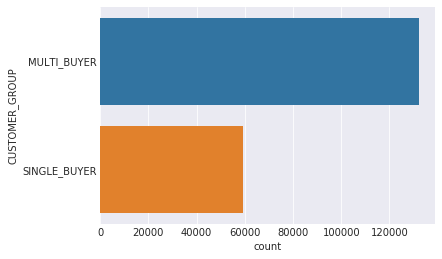

In [154]:
# count plot for CUSTOMER_GROUP feature
sns.countplot(y='CUSTOMER_GROUP', data=customers)
plt.show()

In [50]:
# explore feature with mixed datatype
customers['CAMEO_DEUG_2015'].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

### Insights
Seems that the data makeup of the `customers` dataset is similar to that of the general census data (`azdias`). Processing steps will be similar, just that the thresholds used to remove columns and rows based on missing data composition will be different.

## Data Cleaning and Engineering function

The data processing steps of cleaning and feature engineering will be encapsulated in the function below. The function will streamline these processes for the `customers` dataset.

In [51]:
def process_data(df):
    # process the CAMEO_INTL data
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].fillna('00')
    df['CAMEO_INTL_2015'] =  df['CAMEO_INTL_2015'].replace('XX', '00')
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: str(x))
    
    # process the CAMEO_DEU data
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].fillna('00')
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', '00')
    df = df.drop(columns=['CAMEO_DEUG_2015'], axis=1)
    
    # removing sparse columns
    missing_cols = df.isnull().sum()
    low_missing_cols = missing_cols[missing_cols < 75000]
    df = df[low_missing_cols.index]
    
    # drop unwanted features
    df = df.drop(['LNR', 'EINGEFUEGT_AM'], axis=1)
    
    # engineer new features for CAMEO_INTL
    df['WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[0]))
    df['FAMILY_AGE_BAND'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[1]))
    # drop the original feature
    df = df.drop(['CAMEO_INTL_2015'], axis=1)
    
    # one-hot encode categorical data
    df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns.values)
    # remove the categorical features
    df = df.drop(df.select_dtypes(include=['object']).columns.values, axis=1)
    
    # flag and fill missing numeric data
    for col in df:
        if df[col].isnull().sum() > 0:
            df[f'{col}_is_missing'] = df[col].isnull().astype(int)
    
    df.fillna(0, inplace=True)
    
    return df
    

In [52]:
customers_cleaned = process_data(customers)
customers_cleaned.shape

(191652, 704)

In [53]:
# Some checks
customers_cleaned.describe()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,UNGLEICHENN_FLAG_is_missing,VERDICHTUNGSRAUM_is_missing,VHA_is_missing,VHN_is_missing,VK_DHT4A_is_missing,VK_DISTANZ_is_missing,VK_ZG11_is_missing,W_KEIT_KIND_HH_is_missing,WOHNDAUER_2008_is_missing,WOHNLAGE_is_missing
count,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,0.344359,1.322653,8.592016,7.536879,3.672213,0.049084,0.103239,1.716455,3.476562,0.015434,...,0.243128,0.263373,0.243128,0.283117,0.249781,0.249781,0.249781,0.280415,0.243128,0.260509
std,1.391672,1.867720,7.315499,5.790984,12.496959,0.466499,0.433089,1.552439,12.370711,0.132730,...,0.428973,0.440464,0.428973,0.450514,0.432887,0.432887,0.432887,0.449203,0.428973,0.438913
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,9.000000,9.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,15.000000,12.000000,2.000000,0.000000,0.000000,3.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,9.000000,21.000000,25.000000,523.000000,23.000000,8.000000,21.000000,375.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
customers_cleaned.isnull().sum().sum()

0

### Normalize the Data

Now that we have cleaned up both datasets, we apply scaling transformations to our cleaned data using `MinMaxScaler()`. 

In [55]:
scaler = MinMaxScaler()

# scale the general census data
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned.astype(float)))

# rename the columns of azdias_scaled to that of the columns in azdias_cleaned 
azdias_scaled.columns = azdias_cleaned.columns

In [56]:
azdias_scaled.describe()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,RT_UEBERGROESSE_is_missing,STRUKTURTYP_is_missing,UMFELD_ALT_is_missing,UMFELD_JUNG_is_missing,VERDICHTUNGSRAUM_is_missing,VHN_is_missing,VK_DHT4A_is_missing,VK_DISTANZ_is_missing,VK_ZG11_is_missing,W_KEIT_KIND_HH_is_missing
count,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,...,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000
mean,0.176729,0.429999,0.515195,0.015875,0.002047,0.013097,0.038413,0.017352,0.001035,0.352074,...,0.006861,0.005279,0.004488,0.004488,0.005279,0.009696,0.002943,0.002943,0.002943,0.041903
std,0.308504,0.456203,0.363587,0.029223,0.015951,0.044118,0.025833,0.032071,0.017071,0.113284,...,0.082548,0.072462,0.066842,0.066842,0.072462,0.097990,0.054168,0.054168,0.054168,0.200368
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.003731,0.000000,0.000000,0.022222,0.002227,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.250000,0.619048,0.007463,0.000000,0.000000,0.022222,0.008909,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,1.000000,0.809524,0.018657,0.000000,0.000000,0.044444,0.020045,0.000000,0.444444,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Data Modeling

Clustering algorithms like K-Means rely on finding clusters in an n-dimensional feature space. For high-dimensional datasets such as ours', the clustering algorithm might **face difficulty determining the more important features, thus resulting in noisier clusters.**

Some dimensions have less importance compared to others. For egs, if every population is entirely made up of wealthy people, then this feature that measures wealth has not much significance; it will not help to separate our dataset into clusters based on wealth, because the value *does not vary*.

Instead, we want to **find features that explain the most variance** in the dataset. 

Therefore, we apply **Principal Component Analysis** to reduce dimensionality by combining existing features together to form *principal components* that are **linearly independent of each other and captures the most variance.** Hence, resulting in a denser, new feature set.

## Dimensionality Reduction using SkLearn's PCA

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as **weighted, linear combinations of existing features** that are designed to be **linearly independent** and account for the **largest possible variability in the data**. It can be thought of as taking many features and combining similar or redundant features together to **form a new, smaller feature set**.

## Train the PCA Model

We fit the PCA model with the scaled general population data and generate the predicted principal components as a numpy array.

In [57]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA(random_state=42)
azdias_pca = pca.fit_transform(azdias_scaled)

## Accessing the PCA Model Attributes

After training the model, we can access its underlying parameters.

### PCA Model Attributes

Three types of model attributes are contained within the PCA model.

  * `mean`: The mean that was subtracted from a component in order to center it.
  * `components_`: The features that make up each of the principal components.
  * `explained_variance_ratio_`: Provides the percentage of the total data's variance captured by each of the generated principal components.
  
We are only interested in `components_` and `explained_variance_ratio_`.

### Finding the maximum number of components needed to capture the most variance

In [59]:
num_components = len(pca.explained_variance_ratio_)

# get the array of percentages from the fit pca object
vals = pca.explained_variance_ratio_

# get the array of cumulative captured variance
cumvals = np.cumsum(vals)

In practice, we can aim for a number of principal components that can capture **80-90% variance.**

From trial-and-error, we can see that the **top 110 principal components** for the pca-transformed azdias dataset accounts for **81%** of our total variance. 

In [60]:
# trial and error
top_n_components = 110

# get the cumulative variance from the top n components
captured_variance = cumvals[top_n_components]

print(f"The top {top_n_components} principal components captured {captured_variance} of the total variance.")

The top 110 principal components captured 0.8157147607882433 of the total variance.


### Discussion: Dimensionality reduction

The **top 110 principal components captured about 81% of the total variance**. 

Hence we refit the PCA instance and perform the transformation using the decided number of principal components.

In [61]:
%%time
pca = PCA(n_components=110, random_state=42)
# get the transformed data matrix with the decided number of components
azdias_pca = pca.fit_transform(azdias_scaled)

CPU times: user 2min 10s, sys: 17 s, total: 2min 27s
Wall time: 59.7 s


In [62]:
def display_component_sklearn(pca, features_list, component_num, n_weights=10):

    v_1 = list(pca.components_[component_num])

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    
    top_10_features = list(sorted_weight_data.features[:10])
    
    plt.show()

    return top_10_features

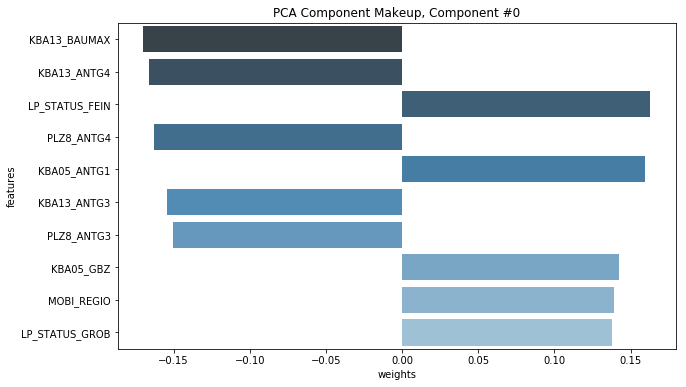

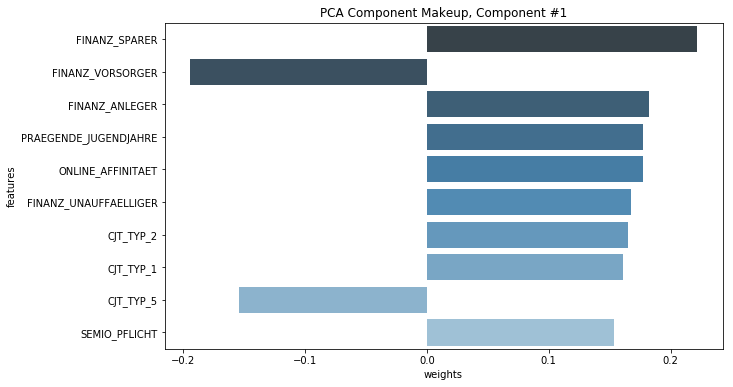

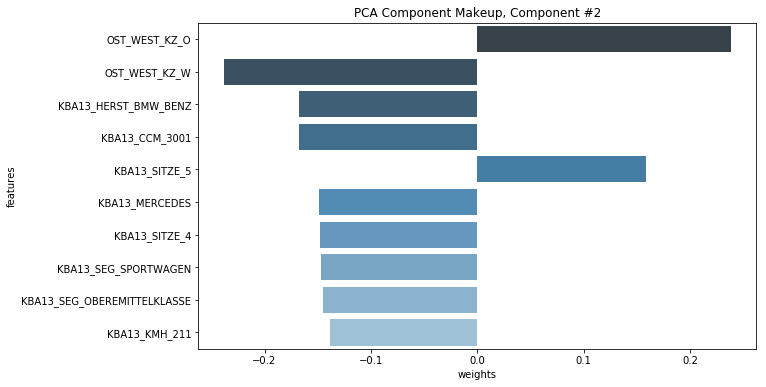

In [63]:
# In sklearn, components_ are sorted by explained_variance, in descending order (i.e. the 1st component captures the most variance)
for i in range(3):
    nth_pc = i
    features_list = azdias_scaled.columns.values
    top_features = display_component_sklearn(pca, features_list, component_num=nth_pc)

### Discussion: Intepretation of principal components

The plots above show the corresponding weights of the top 10 features in each of the principal components. The weights plots of the top 3 components are shown.

Note that the features within each principal component is not independent on each other; only the principal components themselves are independent of each other.

  * 1st Principal Component: positively correlated with 'fine social status', the number of 1-2 families within a cell, number of buildings in a cell, mobility, and 'rough social status'. Negatively correlated with the features 'most common building type', number of >10 family houses in the KBA13, number of >10 family houses in the PLZ8, number of 6-10 family houses in the KBA13 and PLZ8
  
  *  2nd Principal Component: Positively correlated features are 'money savers', 'investors', 'dominating movement in the person's youth (avatgarde or mainstream)', 'online affinity', 'financially unremarkable', 'customer journey typo9logy relating to the preferred information and buying channels', 'whether the person is social'. Negatively correlated with features 'minimalists', and a certain type of CJT
  
  *  3rd Principal component: Positively correlated with features 'former affinity with east germany', 'number of cars with 5 seats is KBA13', and negatively correlated with the features 'former affinity with west germany', 'share of BMW and mercedes benz in the KBA13', 'share of cars with >3001 cc in the KBA13', 'share of mercedes in the kba13', 'number of cars with 4 seats', 'share of upper and middle class cars in the KBA13', 'share of cars in the KBA13 with greater than 211 max speed'.
  
The values of the principal components can be positively or negatively correlated with the features that make it up. For example, PC0 will have a higher value if 'LP_STATUS_FEIN' is higher, or have a lower value if 'KBA13_ANTG3' has a higher value.

We can also infer the theme of the principal component. For example, PC0 seems to draw relationships between building types and family sizes. PC1 seems to draw relationships between financial status and mindsets. PC2 seems to draw relationships between car types and former political affiliations. 

# Population Segmentation

We shall use the k-Means unsupervised clustering algorithm to segment the customers and general population using their PCA attributes.

k-Means is a clustering algorithm that identifies clusters of similar data points based on their component makeup.

## Choosing 'k'

A good 'k' will be one such that the data points in a single cluster are close together but there are enough clusters to effectively separate the data. A bad 'k' will be one that results in very few data points being close to the cluster centers, or one that results in data points being too far away from the cluster centers.

We will select a k such that the data points in a single cluster are close together but there are enough clusters to effectively separate the data.

This can be done by measuring how close our data points are to each cluster, and the average centroid distance between cluster points and a centroid.

After trying several values of k, the centroid distance typically reaches some 'elbow'; it stops decreasing at a sharp rate and this indicates a good value of k.

# Predicting using SkLearn's KMeans

We will use sklearn's `KMeans` class to perform k-means clustering on the PCA-transformed data.

The KMeans' `.score()` method will give the average distance from each point to its assigned cluster's center.

In [64]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans_scores = []

for i in range(2, 21, 1):
    kmeans = MiniBatchKMeans(i)
    kmeans.fit(azdias_pca)
    score = np.abs(kmeans.score(azdias_pca))
    print(f'For {i} clusters, average point-to-centroid distances = {score}')
    kmeans_scores.append(score)

For 2 clusters, average point-to-centroid distances = 13667093.661575507
For 3 clusters, average point-to-centroid distances = 13207264.753168482
For 4 clusters, average point-to-centroid distances = 12738427.620164182
For 5 clusters, average point-to-centroid distances = 12447796.579107864
For 6 clusters, average point-to-centroid distances = 12033863.574805656
For 7 clusters, average point-to-centroid distances = 11818248.154382119
For 8 clusters, average point-to-centroid distances = 11608916.886271885
For 9 clusters, average point-to-centroid distances = 11560641.32792498
For 10 clusters, average point-to-centroid distances = 11308914.143176269
For 11 clusters, average point-to-centroid distances = 11247367.88619099
For 12 clusters, average point-to-centroid distances = 11139451.155626535
For 13 clusters, average point-to-centroid distances = 11016390.11559442
For 14 clusters, average point-to-centroid distances = 10972329.23242859
For 15 clusters, average point-to-centroid distanc

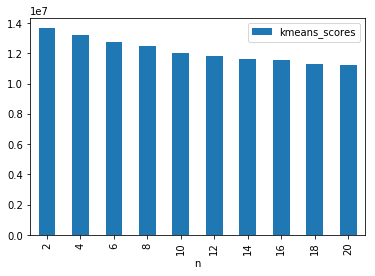

In [65]:
# plot a graph to visualize the change in intra-cluster distance across the different cluster number parameters
n = list(range(2, 22, 2))
cluster_df = pd.DataFrame(list(zip(kmeans_scores, n)))
# name the columns
cluster_df.columns = ['kmeans_scores', 'n']
# cluster_df.set_axis(['kmeans_scores', 'n'], axis=1, inplace=True)
cluster_df.plot.bar(x='n', y='kmeans_scores')

### Discussion: Number of k-clusters to choose for efficient segmentation of the general population 

Chose **8 clusters** to segment the population, since after 8 clusters, the **rate of decrease in the avg distance is smaller**. Hence the additional benefit from using additional clusters beyond this point is smaller as per the law of diminishing returns.

In [66]:
%%time
# refit the kmeans model with the selected number of clusters, then cluster the predictions for the general pop
kmeans = MiniBatchKMeans(n_clusters=8, random_state=42)
clusters_azdias = kmeans.fit_predict(azdias_pca) # feed in the object returned by pca.fit_transform, which is a nd.numpy array

CPU times: user 6.59 s, sys: 582 ms, total: 7.17 s
Wall time: 6.65 s


## PCA-transform and cluster the customer data

Here, we clean and scale the customer dataset, before using the PCA model (trained with the general population data) to generate principal components, thereafter applying the KMeans model to cluster these components.

**DO NOT FIT** THE PCA MODEL WITH THE CUSTOMERS DATASET! (hence use `.transform()` instead of `.fit_transform()` for pca, and use `.predict()` instead of `.fit_predict()` for kmeans)

In [67]:
# filter the customers dataset to only contain features from the azdias dataset that were used to fit the PCA model
customers_cleaned = customers_cleaned[list(azdias_cleaned.columns.values)]

In [68]:
# scale the customers data
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned.astype(float)))

customers_scaled.columns = customers_cleaned.columns

In [69]:
customers_scaled.describe()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,RT_UEBERGROESSE_is_missing,STRUKTURTYP_is_missing,UMFELD_ALT_is_missing,UMFELD_JUNG_is_missing,VERDICHTUNGSRAUM_is_missing,VHN_is_missing,VK_DHT4A_is_missing,VK_DISTANZ_is_missing,VK_ZG11_is_missing,W_KEIT_KIND_HH_is_missing
count,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,0.336090,0.146961,0.409144,0.007021,0.002134,0.012905,0.081736,0.009271,0.003087,0.231207,...,0.230585,0.263373,0.263227,0.263227,0.263373,0.283117,0.249781,0.249781,0.249781,0.280415
std,0.347918,0.207524,0.348357,0.023895,0.020283,0.054136,0.073926,0.032989,0.026546,0.168625,...,0.421208,0.440464,0.440386,0.440386,0.440464,0.450514,0.432887,0.432887,0.432887,0.449203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.250000,0.111111,0.428571,0.001912,0.000000,0.000000,0.095238,0.002667,0.000000,0.222222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.750000,0.111111,0.714286,0.003824,0.000000,0.000000,0.142857,0.005333,0.000000,0.333333,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
%%time
# get the pca-transformed data matrix for the customers dataset, using the pca object fit on the general population data
customers_pca = pca.transform(customers_scaled)

# cluster predictions for the customers' pca-transformed data, by using the kmeans model fit on the general population data  
clusters_cust = kmeans.predict(customers_pca)

CPU times: user 2.72 s, sys: 440 ms, total: 3.16 s
Wall time: 1.6 s


# Comparing Customer Clusters to General Population Clusters

We make comparisons between the proportion of persons in each cluster for the general population, and the proportion of persons in each cluster for the customers population.

For example, if a cluster represents about 10% of the total general population, and the same cluster representing 20% of the total customers population (20% of customer data closest to that centroid), this means that people in this cluster have characteristics that make them a target audience for the client's product.

Likewise, if the cluster represents about 10% of the total population, and 5% of the customer population, this means that these people are not the target audience.

We will use Seaborn's `.barplot()` and `.countplot()` functions to visualize the comparison between the customer and general population clusters.

We will look for over-representation and/or under-representations by the customers dataset in each of the clusters, and interpret the principal components that lie in these clusters to infer the characteristics of the customers. We can also use `.inverse_transform()` method of the PCA and MinMaxScaler objects to transform the centroids back to the original data space and interpret the retrieved values directly.

**Inspecting the array of cluster values for each population**

In [71]:
# for the general population
clusters_azdias_df = pd.DataFrame(clusters_azdias, columns=['Cluster'])

In [72]:
clusters_azdias_df.head()

,Cluster
0,7
1,4
2,0
3,2
4,7


In [73]:
# for the customer population
clusters_cust_df = pd.DataFrame(clusters_cust, columns=['Cluster'])
clusters_cust_df.head()

,Cluster
0,7
1,6
2,7
3,6
4,4


In [74]:
# get number of clusters
num_clusters = len(clusters_azdias_df['Cluster'].unique())
num_clusters

8

#### Comparing proportion of data in each of the 8 clusters between the two datasets

In [75]:
azdias_prop = []
cust_prop = []

for i in range(num_clusters):
   
    azdias_prop_i = len(clusters_azdias_df[clusters_azdias_df['Cluster'] == i]) / len(clusters_azdias_df) * 100
    cust_prop_i = len(clusters_cust_df[clusters_cust_df['Cluster'] == i]) / len(clusters_cust_df) * 100

    azdias_prop.append(azdias_prop_i)
    cust_prop.append(cust_prop_i)
    

cluster_list = list(range(0, 8))
prop_df = pd.DataFrame(list(zip(cluster_list, azdias_prop, cust_prop)), columns=['cluster', 'azdias_prop_%', 'cust_prop_%'])

prop_df
        

,cluster,azdias_prop_%,cust_prop_%
0,0,13.705411,12.792979
1,1,9.813917,1.775614
2,2,1.869083,0.486820
3,3,15.853066,6.065682
4,4,18.912171,28.027362
5,5,11.232200,1.242356
6,6,9.775984,19.611588
7,7,18.838169,29.997600


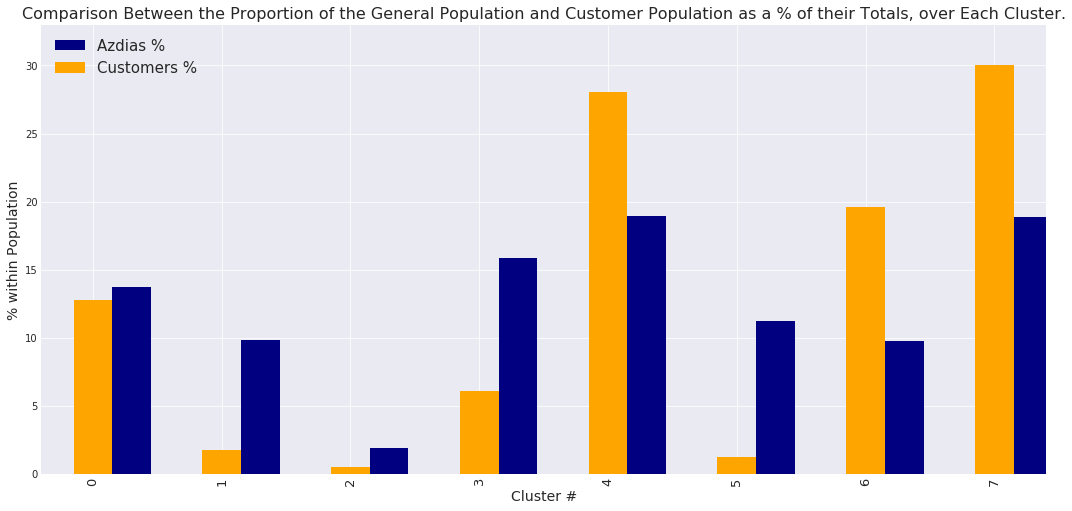

In [76]:
# Visualize with a graph
sns.set_style('darkgrid')

fig = plt.figure(figsize=(18, 8))

ax = fig.add_subplot(111)

ax = prop_df['azdias_prop_%'].plot(x=prop_df['cluster'], 
                                      kind='bar',
                                      color='navy', 
                                      width=0.3, 
                                      align='edge',
                                      position=0)

ax = prop_df['cust_prop_%'].plot(x=prop_df['cluster'], 
                                      kind='bar',
                                      color='orange', 
                                      width=0.3, 
                                      align='edge',
                                      position=1)

ax.margins(x=0.5, y=0.1)
ax.set_xlabel('Cluster #', fontsize=14)
ax.set_ylabel('% within Population', fontsize=14)
ax.xaxis.set(ticklabels=cluster_list)
ax.tick_params(axis='x', which='major', labelsize=13)
plt.xticks(rotation=90,)


plt.legend(('Azdias %', 'Customers %'),fontsize=15)
plt.title(('Comparison Between the Proportion of the General Population and Customer Population as a % of their Totals, over Each Cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.1)
plt.show()

### Analysis of Clusters (Principal Components)

Clusters **4, 6, and 7** are over-represented by Customers, and under-represented for the rest of the clusters.
 
We will dive into the makeup of the principal components present in these clusters 4, 6, and 7 to infer the characteristics of the client's customers.

**First**, we find the principal component that contains the most relevance for each of these 3 clusters by analyzing the cluster centers using `cluster_centers_`.



In [77]:
len(kmeans.cluster_centers_)

8

Each cluster center contains 110 values (dimensions). These correspond to the 110 principle components that we used to fit the kmeans model.

In [78]:
len(kmeans.cluster_centers_[0])

110

#### For clusters with customer over-representations

In [79]:
# for cluster 4
cc4 = kmeans.cluster_centers_[4]
cc4 = pd.DataFrame(cc4, columns=['c'])
cc4 = cc4['c'].sort_values(ascending=False)
cc4.head()

0     1.978207
1     0.870914
3     0.462440
6     0.107942
19    0.086177
Name: c, dtype: float64

In [80]:
# for cluster 6
cc6 = kmeans.cluster_centers_[6]
cc6 = pd.DataFrame(cc6, columns=['c'])
cc6 = cc6['c'].sort_values(ascending=False)
cc6.head()

2     1.062911
0     1.039601
7     0.324807
12    0.164264
11    0.147693
Name: c, dtype: float64

In [81]:
# for cluster 7
cc7 = kmeans.cluster_centers_[7]
cc7 = pd.DataFrame(cc7, columns=['c'])
cc7 = cc7['c'].sort_values(ascending=False)
cc7.head()

0     0.572309
3     0.239673
8     0.116237
15    0.060295
30    0.039555
Name: c, dtype: float64

#### For clusters with under-representation of customers

In [82]:
# for cluster 5 (under-rep)
cc5 = kmeans.cluster_centers_[5]
cc5 = pd.DataFrame(cc5, columns=['c'])
cc5 = cc5['c'].sort_values(ascending=False)
cc5.head()

4     1.015924
1     0.577090
8     0.093199
6     0.089595
10    0.080475
Name: c, dtype: float64

In [83]:
# for cluster 3 (under-rep)
cc3 = kmeans.cluster_centers_[3]
cc3 = pd.DataFrame(cc3, columns=['c'])
cc3 = cc3['c'].sort_values(ascending=False)
cc3.head()

3    0.910557
6    0.226419
9    0.169706
7    0.158154
4    0.090337
Name: c, dtype: float64

In [84]:
# for cluster 1 (under-rep)
cc1 = kmeans.cluster_centers_[1]
cc1 = pd.DataFrame(cc1, columns=['c'])
cc1 = cc1['c'].sort_values(ascending=False)
cc1.head()

2     1.627908
1     0.421432
8     0.281701
3     0.127585
11    0.092342
Name: c, dtype: float64

#### Inference

**Top PCs for strong customer rep**
  * Cluster 4: PC0 / PC1
  * Cluster 6: PC0 / PC2
  * Cluster 7: PC0 / PC3
  
**Top PCs for weak customer rep**
  * Cluster 1: PC2 / PC1
  * Cluster 3: PC3 / PC6
  * Cluster 5: PC4 / PC1

### Analysis of Clusters Part 2 (Feature weights)

Now, we find the features that carry the most **weight** (positive and negative) for each of these principal components.

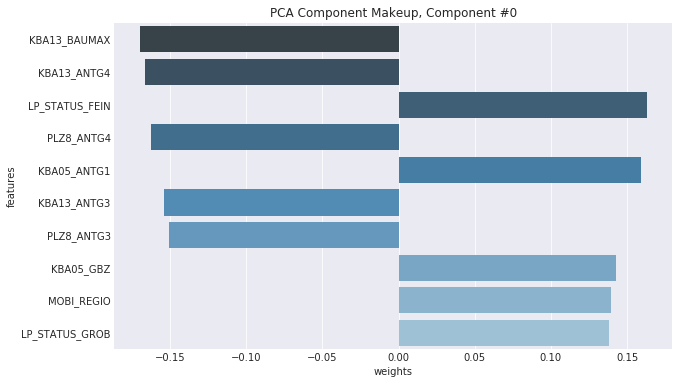

In [85]:
# For strong customer reps
nth_pc = 0
top_10_features_pc0 = display_component_sklearn(pca, features_list, component_num=nth_pc)

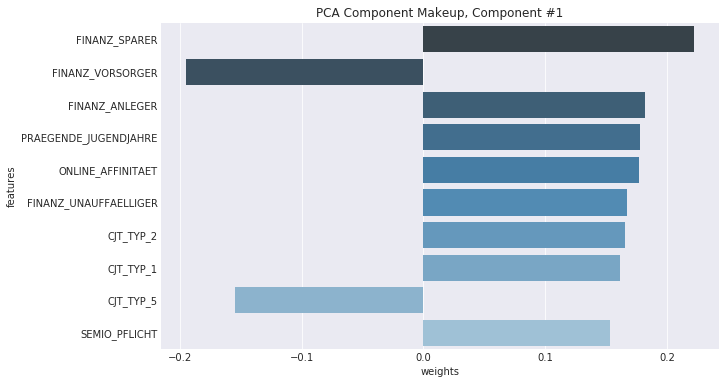

In [86]:
nth_pc = 1
top_10_features_pc1 = display_component_sklearn(pca, features_list, component_num=nth_pc)

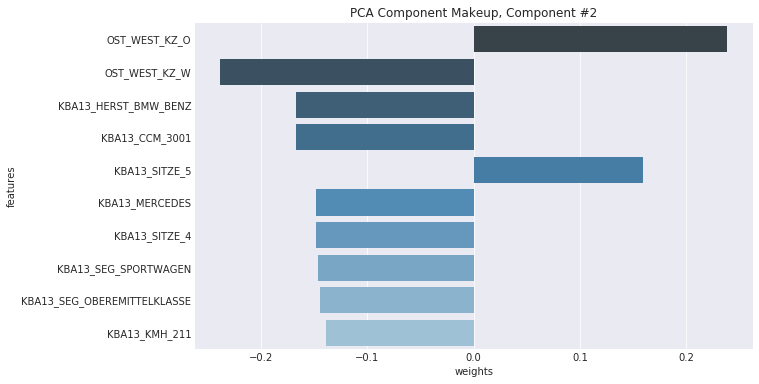

In [87]:
nth_pc = 2
top_10_features_pc2 = display_component_sklearn(pca, features_list, component_num=nth_pc)

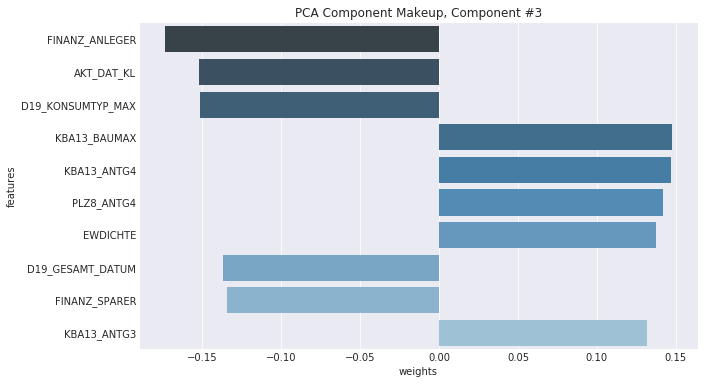

In [88]:
nth_pc = 3
top_10_features_pc3 = display_component_sklearn(pca, features_list, component_num=nth_pc)

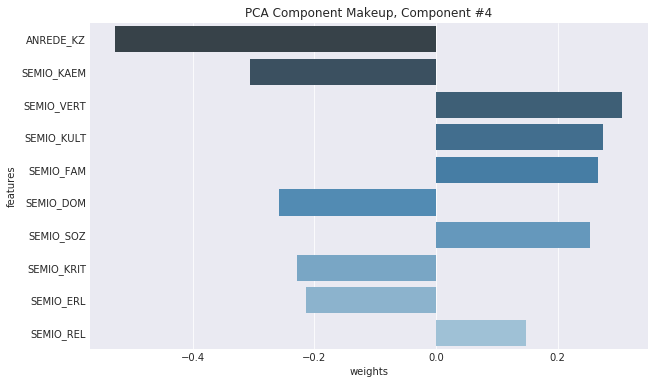

In [89]:
nth_pc = 4
top_10_features_pc4 = display_component_sklearn(pca, features_list, component_num=nth_pc)

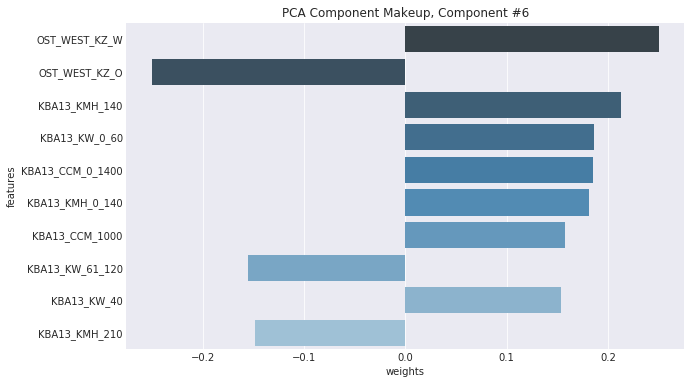

In [90]:
nth_pc = 6
top_10_features_pc6 = display_component_sklearn(pca, features_list, component_num=nth_pc)

### Get original feature values in each cluster centroid

In [91]:
# for strong reps

# transform cluster 4 to original feature values
customer_over_rep4 = scaler.inverse_transform(pca.inverse_transform(cc4).reshape(1, -1))
customer_over_rep4 = pd.Series(customer_over_rep4.squeeze()).round(2)
customer_over_rep4.index = features_list

# transform cluster 6
customer_over_rep6 = scaler.inverse_transform(pca.inverse_transform(cc6).reshape(1, -1))
customer_over_rep6 = pd.Series(customer_over_rep6.squeeze()).round(2)
customer_over_rep6.index = features_list

# transform cluster 7
customer_over_rep7 = scaler.inverse_transform(pca.inverse_transform(cc7).reshape(1, -1))
customer_over_rep7 = pd.Series(customer_over_rep7.squeeze()).round(2)
customer_over_rep7.index = features_list

In [92]:
# For weak reps

# transfomr cluster 1
customer_under_rep1 = scaler.inverse_transform(pca.inverse_transform(cc1).reshape(1, -1))
customer_under_rep1 = pd.Series(customer_under_rep1.squeeze()).round(2)
customer_under_rep1.index = features_list

# transform cluster 3
customer_under_rep3 = scaler.inverse_transform(pca.inverse_transform(cc3).reshape(1, -1))
customer_under_rep3 = pd.Series(customer_under_rep3.squeeze()).round(2)
customer_under_rep3.index = features_list

# transform cluster 5
customer_under_rep5 = scaler.inverse_transform(pca.inverse_transform(cc5).reshape(1, -1))
customer_under_rep5 = pd.Series(customer_under_rep5.squeeze()).round(2)
customer_under_rep5.index = features_list

**Strong reps**

In [93]:
# Show the values of the top features in the top principal components of the clusters

# PC0 in cluster 4
customer_over_rep4[top_10_features_pc0]

KBA13_BAUMAX      0.13
KBA13_ANTG4       0.19
LP_STATUS_FEIN    7.40
PLZ8_ANTG4        0.22
KBA05_ANTG1       2.56
KBA13_ANTG3       0.88
PLZ8_ANTG3        0.91
KBA05_GBZ         3.99
MOBI_REGIO        3.85
LP_STATUS_GROB    3.53
dtype: float64

In [94]:
# PC1 in cluster 4
customer_over_rep4[top_10_features_pc1]

FINANZ_SPARER             2.73
FINANZ_VORSORGER          3.21
FINANZ_ANLEGER            3.17
PRAEGENDE_JUGENDJAHRE    10.54
ONLINE_AFFINITAET         4.40
FINANZ_UNAUFFAELLIGER     2.73
CJT_TYP_2                 2.96
CJT_TYP_1                 3.31
CJT_TYP_5                 3.23
SEMIO_PFLICHT             4.37
dtype: float64

In [95]:
# PC0 in cluster 6
customer_over_rep6[top_10_features_pc0]

KBA13_BAUMAX      1.26
KBA13_ANTG4       0.54
LP_STATUS_FEIN    5.24
PLZ8_ANTG4        0.57
KBA05_ANTG1       1.92
KBA13_ANTG3       1.24
PLZ8_ANTG3        1.34
KBA05_GBZ         3.39
MOBI_REGIO        3.16
LP_STATUS_GROB    2.66
dtype: float64

In [96]:
# PC2 in cluster 6
customer_over_rep6[top_10_features_pc2]

OST_WEST_KZ_O                  0.33
OST_WEST_KZ_W                  0.67
KBA13_HERST_BMW_BENZ           2.68
KBA13_CCM_3001                 1.74
KBA13_SITZE_5                  2.68
KBA13_MERCEDES                 2.94
KBA13_SITZE_4                  2.32
KBA13_SEG_SPORTWAGEN           2.39
KBA13_SEG_OBEREMITTELKLASSE    2.34
KBA13_KMH_211                  2.21
dtype: float64

In [97]:
# PC0 in cluster 7
customer_over_rep7[top_10_features_pc0]

KBA13_BAUMAX      1.37
KBA13_ANTG4       0.63
LP_STATUS_FEIN    4.50
PLZ8_ANTG4        0.64
KBA05_ANTG1       1.80
KBA13_ANTG3       1.29
PLZ8_ANTG3        1.37
KBA05_GBZ         3.22
MOBI_REGIO        2.97
LP_STATUS_GROB    2.42
dtype: float64

In [98]:
# PC3 in cluster 7
customer_over_rep7[top_10_features_pc3]

FINANZ_ANLEGER       2.32
AKT_DAT_KL           3.10
D19_KONSUMTYP_MAX    4.45
KBA13_BAUMAX         1.37
KBA13_ANTG4          0.63
PLZ8_ANTG4           0.64
EWDICHTE             3.25
D19_GESAMT_DATUM     5.85
FINANZ_SPARER        2.74
KBA13_ANTG3          1.29
dtype: float64

**Weak reps**

In [99]:
# PC2 in cluster 1
customer_under_rep1[top_10_features_pc2]

OST_WEST_KZ_O                  0.28
OST_WEST_KZ_W                  0.72
KBA13_HERST_BMW_BENZ           2.86
KBA13_CCM_3001                 1.78
KBA13_SITZE_5                  2.83
KBA13_MERCEDES                 3.20
KBA13_SITZE_4                  2.12
KBA13_SEG_SPORTWAGEN           2.33
KBA13_SEG_OBEREMITTELKLASSE    2.42
KBA13_KMH_211                  2.03
dtype: float64

In [100]:
# PC1 in cluster 1
customer_under_rep1[top_10_features_pc1]

FINANZ_SPARER            2.51
FINANZ_VORSORGER         2.89
FINANZ_ANLEGER           2.19
PRAEGENDE_JUGENDJAHRE    9.42
ONLINE_AFFINITAET        3.93
FINANZ_UNAUFFAELLIGER    3.10
CJT_TYP_2                2.43
CJT_TYP_1                2.64
CJT_TYP_5                3.90
SEMIO_PFLICHT            4.00
dtype: float64

In [101]:
# PC3 in cluster 3
customer_under_rep3[top_10_features_pc3]

FINANZ_ANLEGER       2.03
AKT_DAT_KL           2.57
D19_KONSUMTYP_MAX    3.86
KBA13_BAUMAX         1.22
KBA13_ANTG4          0.62
PLZ8_ANTG4           0.63
EWDICHTE             2.96
D19_GESAMT_DATUM     5.37
FINANZ_SPARER        2.59
KBA13_ANTG3          1.16
dtype: float64

In [102]:
# PC6 in cluster 3
customer_under_rep3[top_10_features_pc6]

OST_WEST_KZ_W       0.74
OST_WEST_KZ_O       0.26
KBA13_KMH_140       1.70
KBA13_KW_0_60       2.62
KBA13_CCM_0_1400    2.09
KBA13_KMH_0_140     1.64
KBA13_CCM_1000      3.00
KBA13_KW_61_120     2.36
KBA13_KW_40         3.00
KBA13_KMH_210       2.56
dtype: float64

In [103]:
# PC4 in cluster 5
customer_under_rep5[top_10_features_pc4]

ANREDE_KZ     1.47
SEMIO_KAEM    3.94
SEMIO_VERT    4.20
SEMIO_KULT    4.28
SEMIO_FAM     4.17
SEMIO_DOM     4.84
SEMIO_SOZ     4.18
SEMIO_KRIT    4.23
SEMIO_ERL     4.09
SEMIO_REL     4.20
dtype: float64

In [104]:
# PC1 in cluster 5
customer_under_rep5[top_10_features_pc1]

FINANZ_SPARER             2.94
FINANZ_VORSORGER          2.97
FINANZ_ANLEGER            2.86
PRAEGENDE_JUGENDJAHRE    10.18
ONLINE_AFFINITAET         3.73
FINANZ_UNAUFFAELLIGER     2.97
CJT_TYP_2                 3.04
CJT_TYP_1                 3.24
CJT_TYP_5                 3.31
SEMIO_PFLICHT             4.81
dtype: float64

### Discussion: Comparison of General Population and Customer Representation in the Clusters 

For the clusters with under-representation of customers, they are **cluster 1**, **cluster 3** and  **cluster 5**.

for the clusters with over-representation of customers, I'll use **cluster 4**. 
 

By analyzing the original values of the features in the top principal components (PC0/1 and PC2/5) that make up these cluster's centroids (by applying inverse transformation to the principal components), we can determine the most important features by weight.

For the strong clusters,  the main principal components are PC0, PC1, PC2 and PC3.

For the weak clusters, the main principal components are PC1, PC2, PC3 and PC6.


**Cluster 4 for customer attributes:**
Top features of positive weight for PC0 and their original values:
  * LP_STATUS_FEIN: fine social status; *7.4*  --- younger houseowners
  * KBA05_ANTG1: num of 1-2 households; *2.56*  --- neighborhood with above average concentration of 1-2 family homes; suggesting middle-upper class neighborhood
  * KBA05_GBZ: num buildings in microcell; *3.99*  --- 17-22 buildings, suggesting dense, urban population
  * MOBI_REGIO: moving patterns; *3.85* --- low mobility, people tend to stay longer
  * LP_STATUS_GROB: rough social status;  *3.52*  --- average income earners
  
Top features of negative weight for PC0 and their original values:
  * KBA13_BAUMAX: most common building type within kba13; *0.13*   --- mainly 1-2 family homes (confluent with the above)
  * KBA13_ANTG4: num of >10 households in kba13;  *0.19*  --- no >10 family homes (confluent with the above)
  * PLZ8_ANTG4: num of >10 households in plz8;  *0.22*  --- no >10 family homes (confluent with the above)
  * KBA13_ANTG3: num of 6-10 households in kba13; *0.88* --- no >6-10 family homes (confluent with the above)
  * PLZ8_ANTG3: num of 6-10 households in plz8;  *0.91* --- no 6-10 family homes (confluent with the above)
  
Top features of positive weight for PC1 and their original values:
  * FINANZ_SPARER: money saver; *2.73* --- average tendency to save
  * FINANZ_ANLEGER: investor; *3.17* --- average tendency to invest
  * PRAEGENDE_JUGENDJAHRE: dominating movement in youth (avatgarde/mainstream); *10.54*  --- Born in the 80s during the era where there was ecological awareness (avantgarde)
  * ONLINE_AFFINITAET: online affinity; *4.4* --- very high online presence
  * FINANZ_UNAUFFAELLIGER: unremarkable financial status;  *2.73* --- average financial status
  * CJT_TYP_2: buying typology; *2.96* --- shop in stores
  * CJT_TYP_1: buying typology;  *3.31* --- low preference for shopping
  * SEMIO_PFLICHT: affinity for traditional mindsets; *4.37* -- average
  
Top features of negative weight for PC1 and their original values:
  * FINANZ_VORSORGER: financially prepared;  *3.21* --- average financial preparedness
  * CJT_TYP5: buying typology;  *3.23*


**Cluster 1 for non-customer attributes**

Top features of positive weight for PC2 and their original values:
  * OST_WEST_KZ_O: affinity with east germany;  *0.28*  --- score 0 in class 'O', suggesting affinity to the West of Germany
  * KBA13_SITZE_5: number of cars with 5 seats in the plz8;  *2.83* --- low number of cars with 5 seats

Top features of negative weight for PC2 and their original values:
  * OST_WEST_KZ_W: affinity with west germany;  *0.72* --- clost to 1 in class 'W', suggesting affinity to West of Germany
  * KBA13_HERST_BMW_BENZ: share of bmw and benz in plz8  *2.86* --- low-average share of benz and merc
  * KBA13_CCM_3001: share of cars above 3L capacity in plz8;  *1.78* --- low-average share of 3l cars
  * KBA13_MERCEDES: share of mercedes in plz8  *3.2* --- low to average share of merc
  * KBA13_SITZE4: share of cars with 4 seats in plz8;  *2.12* --- low to average share of cars with 4 seats
  * KBA13_SEG_SPORTWAGEN: share of sportswagen in plz8;  *2.33*  --- low share of sportswagen
  * KBA13_SEG_OBEREMITTELKLASSE: share of upper middle class and upper class cars;  *2.42* --- low/average share of middle/upper class cars
  * KBA13_KMH_211: share of cars with max speed greater than 211kmh;  *2.03* --- low/average share of fast cars
  
Top features of positive weight for PC1 and their original values:
  * FINANZ_SPARER: money saver; *2.51* --- average tendency to save
  * FINANZ_ANLEGER: investor; *2.19* --- high tendency to invest
  * PRAEGENDE_JUGENDJAHRE: dominating movement in youth (avatgarde/mainstream); *9.42*
  * ONLINE_AFFINITAET: online affinity; *3.93* --- very high online presence
  * FINANZ_UNAUFFAELLIGER: unremarkable financial status;  *3.1* --- average financial status
  * CJT_TYP_2: buying typology; *2.43* --- shop in stores
  * CJT_TYP_1: buying typology;  *2.64* --- low preference for shopping
  * SEMIO_PFLICHT: affinity for traditional mindsets; *4* -- average
  
Top features of negative weight for PC1 and their original values:
  * FINANZ_VORSORGER: financially prepared;  *2.89* --- average financial preparedness
  * CJT_TYP5: buying typology;  *3.9*
  

**Cluster 5 for non-customer attributes**
Top features of positive weight for PC4 and their original values:
  * SEMIO_VERT: 4.2, average dreamer
  * SEMIO_KULT: 4.28, average culturally inclined
  * SEMIO_FAM: 4.17,, average family-oriented
  * SEMIO_SOZ: 4.18, average social-minded
  * SEMIO_ERL: 4.2, average eventful oriented
  
Top features of negative weight for PC4 and their original values:
  * ANREDE_KZ: 1.47, male 
  * SEMIO_KAEM: 3.94, average aggression
  * SEMIO_DOM: 4.84, not very dominant
  * SEMIO_KRIT: 4.23, average crtically minded
  * SEMIO_REL: 4.2, average religious-minded
  
Top features of positive weight for PC1 and their original values:
  * FINANZ_SPARER: money saver; *2.94* --- average tendency to save
  * FINANZ_ANLEGER: investor; *2.86* --- average tendency to invest
  * PRAEGENDE_JUGENDJAHRE: dominating movement in youth (avatgarde/mainstream); *10.18*
  * ONLINE_AFFINITAET: online affinity; *3.73* --- very high online presence
  * FINANZ_UNAUFFAELLIGER: unremarkable financial status;  *2.97* --- average financial status
  * CJT_TYP_2: buying typology; *3.04* --- shop in stores
  * CJT_TYP_1: buying typology;  *3.24* --- low preference for shopping
  * SEMIO_PFLICHT: affinity for traditional mindsets; *4.81* -- average
  
Top features of negative weight for PC1 and their original values:
  * FINANZ_VORSORGER: financially prepared;  *2.97* --- low/average financial preparedness
  * CJT_TYP5: buying typology;  *3.31*
  

  
  
### Inference

**Customer** attributes: 
  * High/average income earners who are new houseowners, staying in a densely populated area with a high percentage of 1-2 family homes
  * Young couples / singles with children
  * Low mobility; don't move around much
  * sound financial attitudes
  * Have a strong online presence
 
**Non-customer** attributes:
  * Quite conservative with spending; tendency to save and invest their money
  * Middle-class
  * Have a strong online presence
  * Population with low/average numbers of luxury cars
  
  
  
In essence, the client's **target audience** are **young families** who **own homes** in a **densely-populated middle/upper-class area**. They are **financially well-to-do**.

**People who do not buy from the client** are typically those who are more **conservative** with their spending, from an **older generation**, **don't really own luxury cars**, and prefer to **shop in brick and mortar stores**.
  

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## Exploratory Data Analysis

In [106]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [107]:
mailout_train.select_dtypes(include=['object']).describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,35074,35074.0,35074.0,35378,35185,35185
unique,45,19.0,43.0,35,1599,2
top,6B,6.0,24.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,2452,3884.0,3024.0,10276,18156,26752


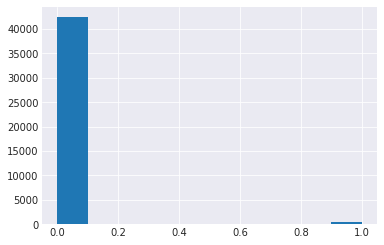

In [108]:
# explore the customer response data
plt.hist(x = mailout_train['RESPONSE'])
plt.show()

In [109]:
# number of people who are customers
mailout_train['RESPONSE'].sum()

532

In [110]:
# percentage of people who are customers
mailout_train['RESPONSE'].mean() * 100

1.2383036171500394

#### Check for columns which have many missing values

In [111]:
mailout_cols_missing = mailout_train.isnull().sum().sort_values(ascending=False)
mailout_cols_missing.head(10)

ALTER_KIND4       42921
ALTER_KIND3       42788
ALTER_KIND2       42206
ALTER_KIND1       40974
KK_KUNDENTYP      25316
EXTSEL992         15948
HH_DELTA_FLAG      9678
W_KEIT_KIND_HH     9678
KBA05_KW2          8648
MOBI_REGIO         8648
dtype: int64

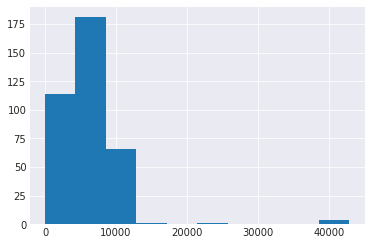

In [112]:
plt.hist(x=mailout_cols_missing, bins=10)
plt.show()

#### Check for rows which have many missing values

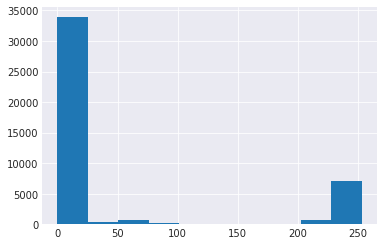

In [113]:
mailout_rows_missing = mailout_train.isnull().sum(axis=1)

plt.hist(x=mailout_rows_missing, bins=10)
plt.show()

## Data Cleaning

In [114]:
# remove columns which have more than 10k missing data
mailout_train_cleaned = mailout_train.loc[:, mailout_train.isnull().sum() < 10000]

In [115]:
mailout_train_processed = process_data(mailout_train_cleaned)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [116]:
mailout_train_processed.shape

(42962, 699)

In [117]:
# check for any missing values
mailout_train_processed.isnull().sum().sum()

0

In [118]:
# take out the target variable column
mailout_response = mailout_train_processed.RESPONSE

In [119]:
mailout_train_p = mailout_train_processed[list(azdias_cleaned.columns.values)]
mailout_train_p.shape

(42962, 444)

## Generate PCA components and Cluster Data

In [120]:
# scale the data first
mailout_train_scaled = pd.DataFrame(scaler.fit_transform(mailout_train_p.astype(float)))

mailout_train_scaled.columns = mailout_train_p.columns

In [121]:
%%time
# pca transform the scaled mailout_train data and generate clusters
pca_mailout_train = pca.transform(mailout_train_scaled)

mailout_train_clusters = kmeans.predict(pca_mailout_train)

CPU times: user 740 ms, sys: 241 ms, total: 981 ms
Wall time: 362 ms


In [122]:
# inspect the clusters
mailout_train_clusters

array([3, 4, 6, ..., 4, 4, 7], dtype=int32)

In [123]:
mailout_train_clusters_df = pd.DataFrame(mailout_train_clusters, columns=['cluster'])
mailout_train_clusters_df.head()

,cluster
0,3
1,4
2,6
3,7
4,7


In [124]:
mailout_train_clusters_df.shape

(42962, 1)

In [125]:
mailout_train_cleaned.shape

(42962, 361)

### Create a Training Set based on Previous Analysis

In the previous section, we determined the attributes of customers and non-customers by determining:
  * the clusters that have an over-representation and under-representation of customers
  * the most relevant principal components in each of those clusters
  * the most heavily weighted features and their corresponding scores
  
We have determined that the population belonging to clusters 4, 6 7 are most likely to be customers, while those belonging to clusters 1, 3 and 5 are more likely to not be customers.

Thus, we will train our data that only belong to these clusters.



In [126]:
# add the column of clusters to our cleaned dataset
mailout_train_cleaned_with_clusters = pd.concat([mailout_train_cleaned, mailout_train_clusters_df], axis=1)
mailout_train_cleaned_with_clusters.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,1.0,6.0,9.0,3.0,3,0,2,4,3
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,2.0,1.0,4.0,9.0,7.0,1,0,2,3,4
2,1776,1,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,4.0,2.0,NaN,9.0,2.0,3,0,1,4,6
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,11.0,11.0,6.0,9.0,1.0,3,0,2,4,7
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,2.0,1.0,6.0,9.0,3.0,3,0,1,3,7


In [127]:
# filter out data which belong only to clusters 1, 3, 5, 4, 6, 7
clusters = [1, 3, 5, 4, 6, 7]
mailout_train_valid_clusters = mailout_train_cleaned_with_clusters[mailout_train_cleaned_with_clusters.cluster.isin(clusters)]
mailout_train_valid_clusters.shape

(37870, 362)

In [128]:
mailout_train_valid_clusters.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,1.0,6.0,9.0,3.0,3,0,2,4,3
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,2.0,1.0,4.0,9.0,7.0,1,0,2,3,4
2,1776,1,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,4.0,2.0,NaN,9.0,2.0,3,0,1,4,6
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,11.0,11.0,6.0,9.0,1.0,3,0,2,4,7
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,2.0,1.0,6.0,9.0,3.0,3,0,1,3,7


In [129]:
mailout_train_valid_clusters_p = process_data(mailout_train_valid_clusters)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [130]:
# save the data that we will be using for model training to a csv
mailout_train_valid_clusters_p.to_csv('analytical_base_table.csv', index=None)

## Train the Supervised Learning Model

In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc

In [133]:
# separate out the target variable
mailout_training = mailout_train_valid_clusters_p

# isolate target variable
y = mailout_training.RESPONSE

# isolate training inputs. Drop the target variable and remove the 'clusters' column
X = mailout_training.drop(['RESPONSE', 'cluster'], axis=1)

In [134]:
# split the data into train and test sets in a 80/20 ratio. Use stratify so we have equal proportions of positive and negative classes on both the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [135]:
# Apply 10-fold cross-validation to help us select the best model and hyperparameters

# Perform pre-processing in a model pipeline
pipelines = {
    'enet' : make_pipeline(MinMaxScaler(),
                          ElasticNet(random_state=42)),
    'rf' : make_pipeline(MinMaxScaler(),
                        RandomForestClassifier(random_state=42)),
    'gb' : make_pipeline(MinMaxScaler(),
                        GradientBoostingClassifier(random_state=42))
}

# Create hyperparameter grids to support hyperparameter tuning at a later stage
enet_hyperparams = {
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

rf_hyperparams = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

gb_hyperparams = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

# hyperparameter dictionary
hyperparameters = {
    'enet': enet_hyperparams,
    'rf': rf_hyperparams,
    'gb': gb_hyperparams
}


# dictionary to store the fit models
fitted_models = {}

# perform grid search while fitting the model
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name],
                        cv=10, n_jobs=-1)
    
    model.fit(X_train, y_train)
    
    # store model in fitted_models
    fitted_models[name] = model
    
    print(f'{name} has been fitted!')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


enet has been fitted!


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


rf has been fitted!


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


gb has been fitted!


## Evaluate the Model

In [136]:
# First evaluation will be to look at the cross-validated score on the training set
for name, model in fitted_models.items():
    print(name, model.best_score_)

enet 0.004831816541123906
rf 0.987490097702667
gb 0.9875231053604436


In [157]:
fitted_models['gb'].best_params_

{'gradientboostingclassifier__learning_rate': 0.05,
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__n_estimators': 100}

In [137]:
# Predict the probability of the target variable (RESPONSE) using the model that obtained the best cv score
pred = fitted_models['gb'].predict_proba(X_test)
pred = [p[1] for p in pred]

#### Area under ROC curve is the most reliable metric for classification tasks

It is equivalent to the probability that a randomly chosen Positive observation is higher than a randomly chosen Negative observation.

In other words, if you took 2 observations and exactly one of them was the positive class and the other was the negative class, what is the likelihood that the model can distinguish the two?

Hence it is the **remedy for evaluating imbalanced classes**.

##### True positive rate (TPR), False positive rate (FPR) and AUC

The TPR is the proportion of all actual positive observations that were predicted correctly as positive.

The FPR is the proportion of all actual negative observations that were predicted as positive. 

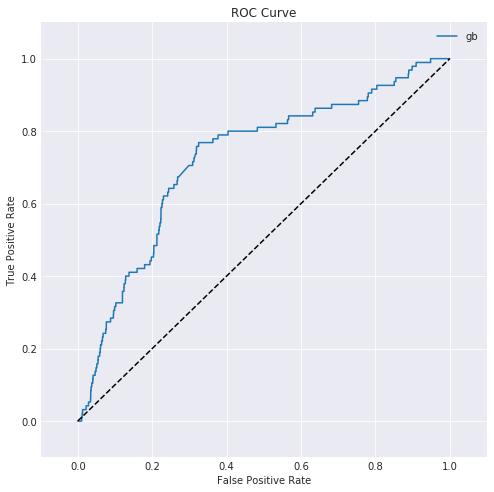

In [138]:
# Calculate the ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

# initialize figure
fig = plt.figure(figsize=(8, 8))
plt.title('ROC Curve')

# plot the ROC curve
plt.plot(fpr, tpr, label='gb')
plt.legend(loc='upper right')

# diagonal 45 degree dotted line
plt.plot([0, 1], [0, 1], 'k--')

# axes limits and labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [139]:
# calculate the ROC
area_under_curve = auc(fpr, tpr)
print(area_under_curve)

0.7227823871753188


In [140]:
# save the model
import pickle

with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [141]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [146]:
lnr_id = mailout_test['LNR']

In [147]:
# pre-process the data for model prediction
mailout_test = mailout_test.loc[:, mailout_test.isnull().sum() < 10000]

mailout_test_processed = process_data(mailout_test)

In [148]:
# pass data into model for prediction
pred_response = fitted_models['gb'].predict_proba(mailout_test_processed)

In [149]:
#retrieve the prediction probabilities
response = [p[1] for p in pred_response]

In [150]:
response_df = pd.DataFrame(response, columns=['RESPONSE'])

In [151]:
# prepare csv for submission
df = pd.concat([lnr_id, response_df], axis=1)

In [152]:
df.to_csv('arvato_submission.csv', index=None)

In [153]:
df.head()

,LNR,RESPONSE
0,1754,0.033907
1,1770,0.028906
2,1465,0.006924
3,1470,0.004398
4,1478,0.004228
